# Handypreisanalyse

In [1]:
import requests
import pandas as pd
import time
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.xkcd()

## Data Generation

In [2]:
product_list = [
    [0, 'Samsung', 'Galaxy S1', 535151],
    [1, 'Samsung', 'Galaxy S2', 615532],
    [2, 'Samsung', 'Galaxy S3', 772300],
    [3, 'Samsung', 'Galaxy S4', 917778],
    [4, 'Samsung', 'Galaxy S5', 1075683],
    [5, 'Samsung', 'Galaxy S6', 1237277],
    [6, 'Samsung', 'Galaxy S7', 1397048],
    [7, 'Samsung', 'Galaxy S8', 1601178],
    [8, 'Samsung', 'Galaxy S9', 1776751],

    [10, 'Apple', 'iPhone 4 16GB schwarz', 538203],
    [11, 'Apple', 'iPhone 4s 16GB black', 687504],
    [12, 'Apple', 'iPhone 5 16GB black', 837396],
    [13, 'Apple', 'iPhone 5s 16GB grey', 999650],
    [14, 'Apple', 'iPhone 6 16GB grey', 1163683],
    [15, 'Apple', 'iPhone 6s 16GB grey', 1322858],
    [16, 'Apple', 'iPhone 7 32GB black', 1504572],
    [17, 'Apple', 'iPhone 8 64GB grey', 1688628],
    [18, 'Apple', 'iPhone X 64GB grey', 1688629],
    
    [18, 'Apple Watch', 'Series 1', 1505399],
    [18, 'Apple Watch', 'Series 2', 1504658],
    [18, 'Apple Watch', 'Series 3 (GPS)', 1688730],

    [19, 'Google', 'Nexus 4 16GB black', 859912],
    [20, 'Google', 'Nexus 5 16GB black', 1025573],
    [21, 'Google', 'Nexus 6 32GB blue', 1181033],
    [22, 'Google', 'Nexus 5X 32GB black', 1331033],
    [23, 'Google', 'Nexus 6P 32GB black', 1331035],
    [24, 'Google', 'Pixel 32GB black', 1517774],
    [25, 'Google', 'Pixel 2 64GB black', 1704861],
    
    [23, 'DJI', 'Phantom 2', 1087828],
    [24, 'DJI', 'Phantom 3 Standard', 1317914],
    [25, 'DJI', 'Phantom 4', 1400938],
    [25, 'DJI', 'Mavic Pro', 1515202],
    [25, 'DJI', 'Spark weiß', 1630267]
]

In [3]:
def scrapePrices(product_list):
    df_raw = pd.DataFrame()

    for product in product_list:
        url = 'https://geizhals.de/?phist='+str(product[3])+'&age=9999'
        print(url)
        r = requests.get(url).text

        prices = r.split('_gh.plot(')[1].split(', ')[1]
        prices = ast.literal_eval(prices)

        df = pd.DataFrame.from_dict(prices)
        df.columns = ['timestamp', 'price']
        
        df['manufacturer'] = product[1]
        df['product'] = product[2]
        df['timestamp'] = df['timestamp'].apply(lambda x: x / 1000)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['market_day'] = df.index   

        df = df[df['market_day'] < 1095]   
        
        df['price_avg_week'] = df['price'].rolling(7).mean()
        df['price_perc'] = df['price'] / df['price'][1:3].mean()
        df['price_perc_week'] = df['price_perc'].rolling(7).mean()
        
        df_raw = df_raw.append(df, ignore_index=True)
        time.sleep(1.5)
    return df_raw

In [4]:
df_raw = scrapePrices(product_list)
df_raw.to_csv('../data/cell_phone_prices.csv', sep='\t', encoding='utf-8')

https://geizhals.de/?phist=535151&age=9999
https://geizhals.de/?phist=615532&age=9999
https://geizhals.de/?phist=772300&age=9999
https://geizhals.de/?phist=917778&age=9999
https://geizhals.de/?phist=1075683&age=9999
https://geizhals.de/?phist=1237277&age=9999
https://geizhals.de/?phist=1397048&age=9999
https://geizhals.de/?phist=1601178&age=9999
https://geizhals.de/?phist=1776751&age=9999
https://geizhals.de/?phist=538203&age=9999
https://geizhals.de/?phist=687504&age=9999
https://geizhals.de/?phist=837396&age=9999
https://geizhals.de/?phist=999650&age=9999
https://geizhals.de/?phist=1163683&age=9999
https://geizhals.de/?phist=1322858&age=9999
https://geizhals.de/?phist=1504572&age=9999
https://geizhals.de/?phist=1688628&age=9999
https://geizhals.de/?phist=1688629&age=9999
https://geizhals.de/?phist=1505399&age=9999
https://geizhals.de/?phist=1504658&age=9999
https://geizhals.de/?phist=1688730&age=9999
https://geizhals.de/?phist=859912&age=9999
https://geizhals.de/?phist=1025573&age=99

In [5]:
df_raw = pd.read_csv('../data/cell_phone_prices.csv', sep='\t', encoding='utf-8')
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

## Analyse

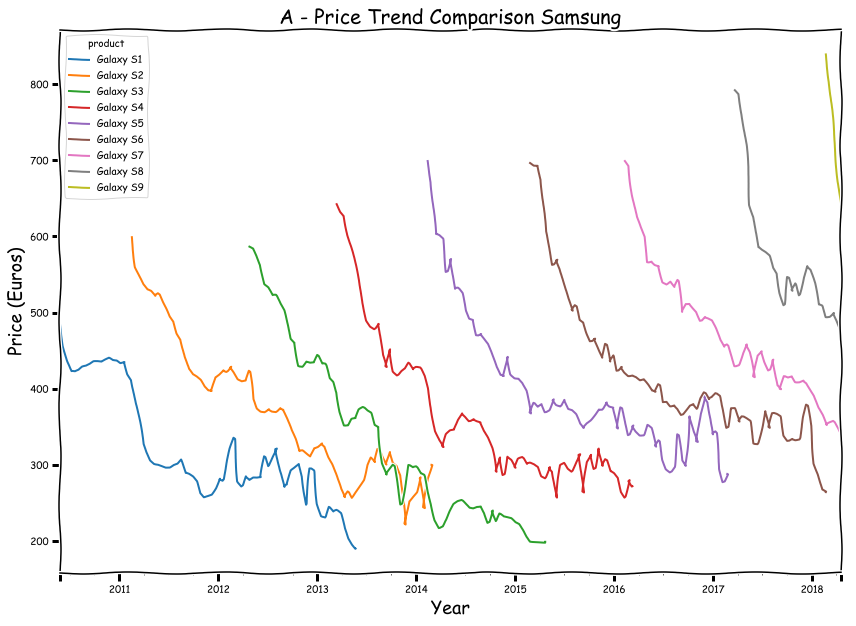

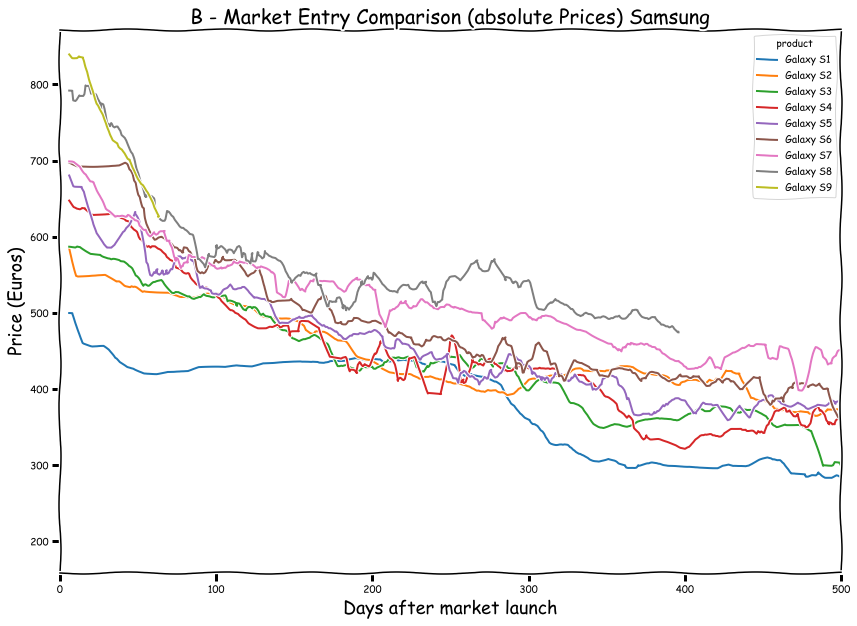

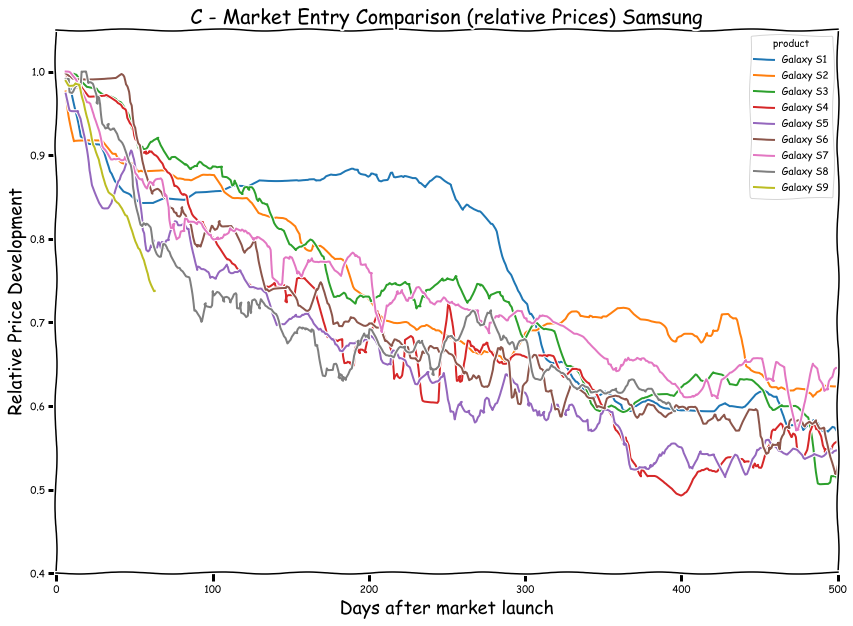

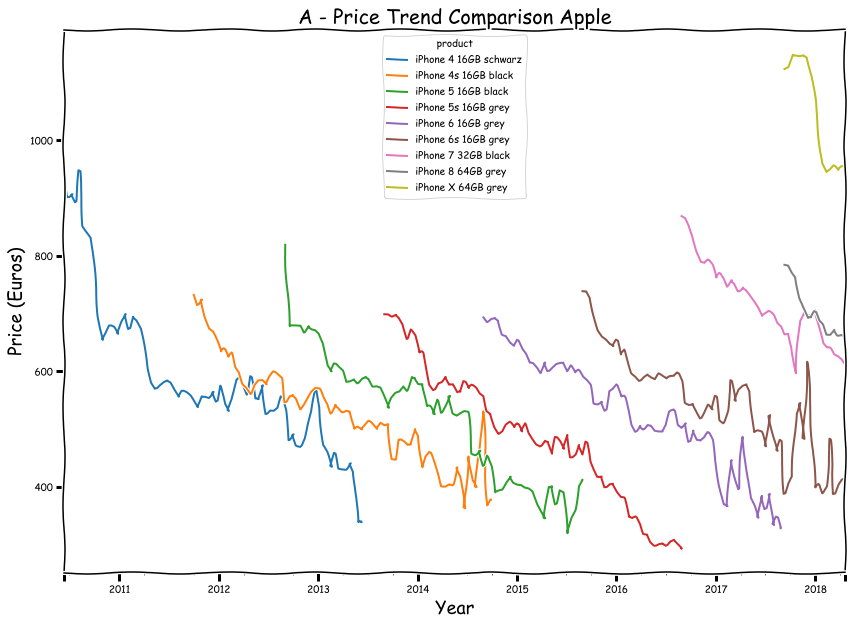

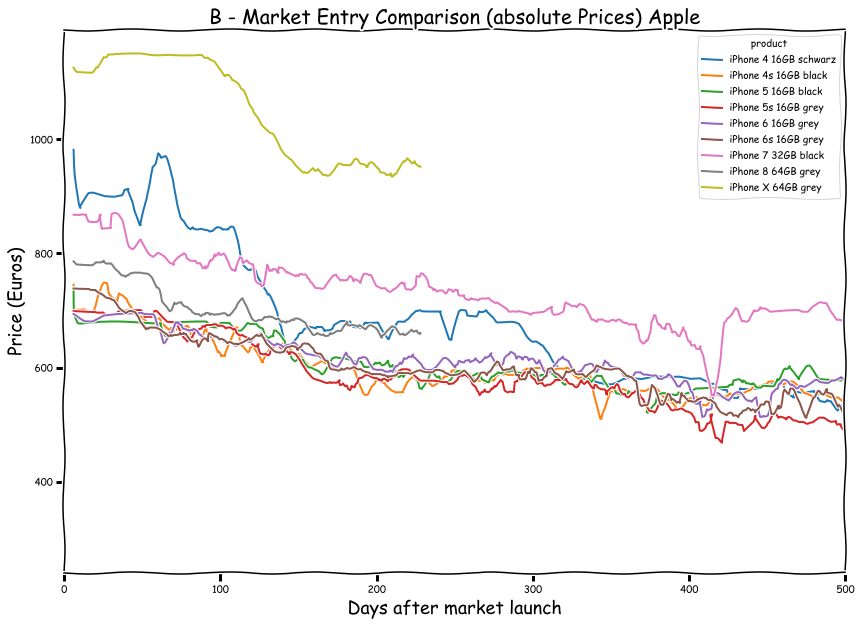

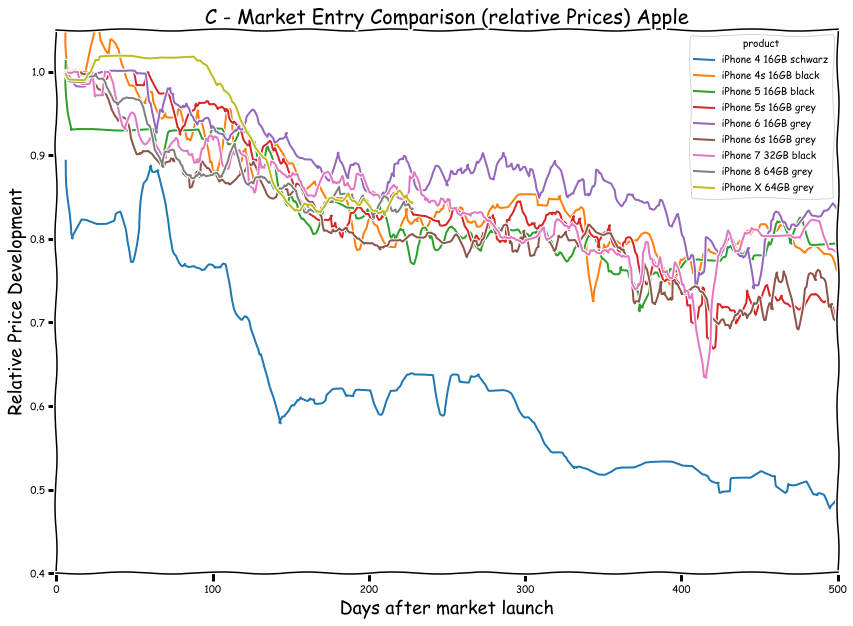

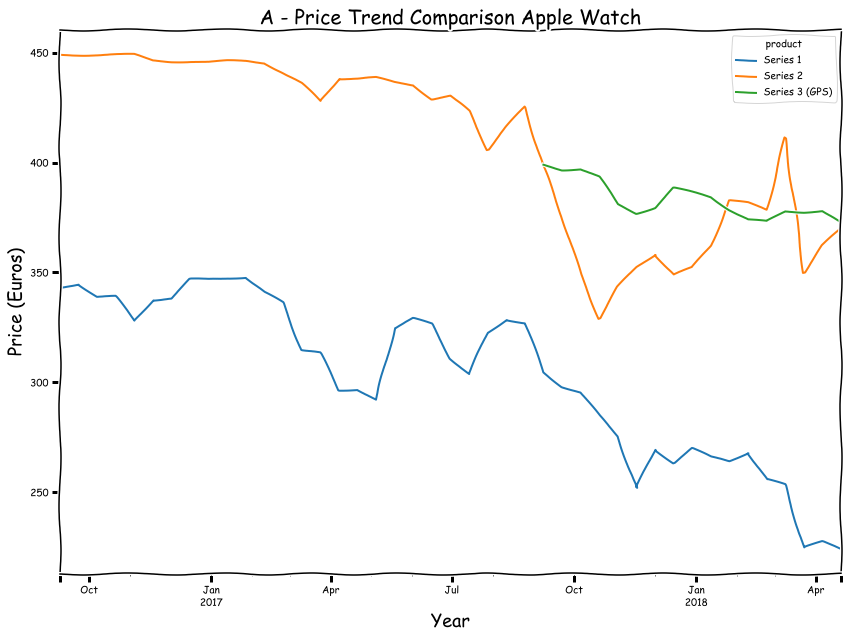

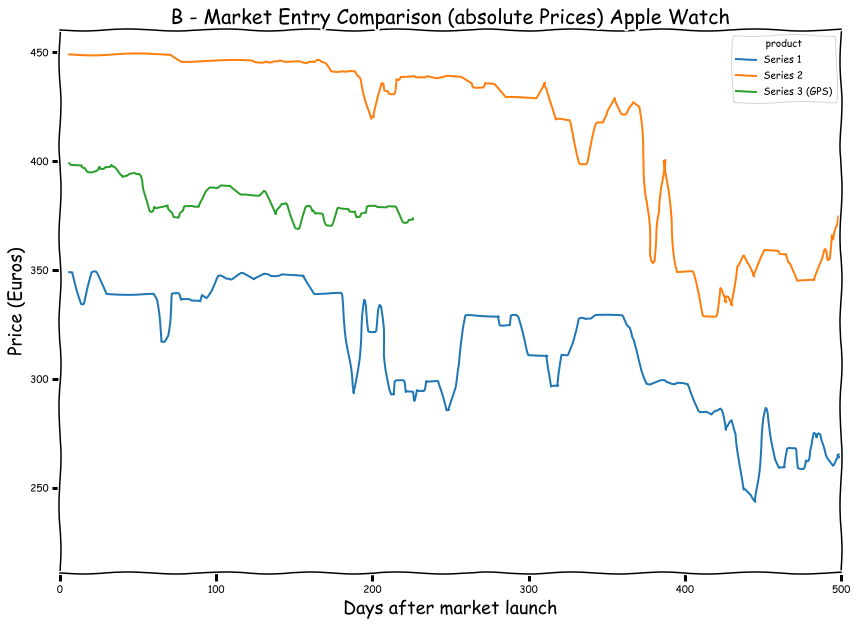

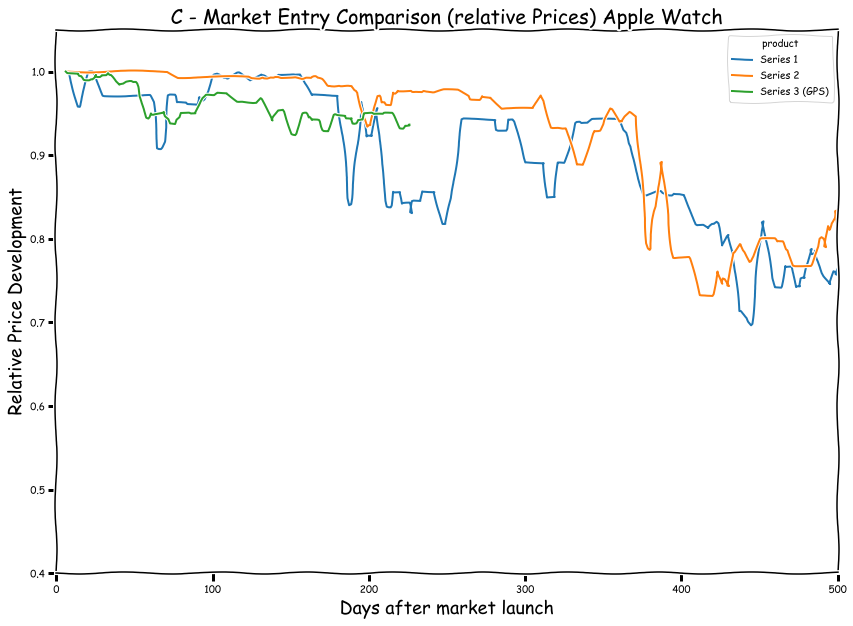

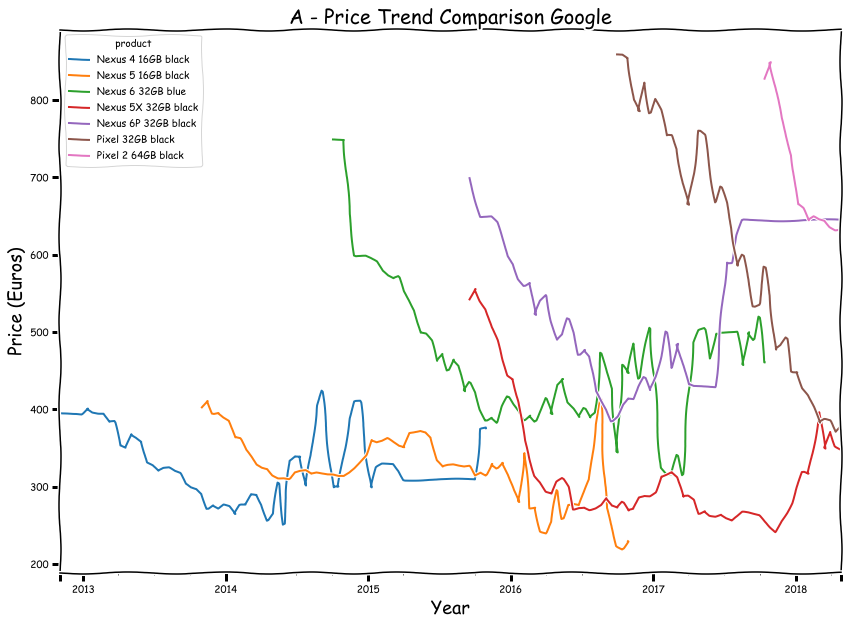

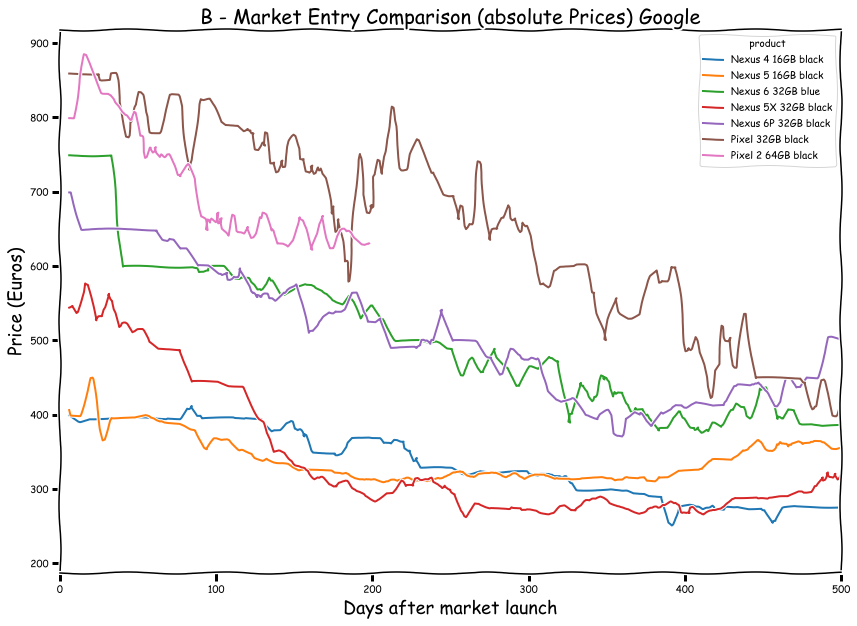

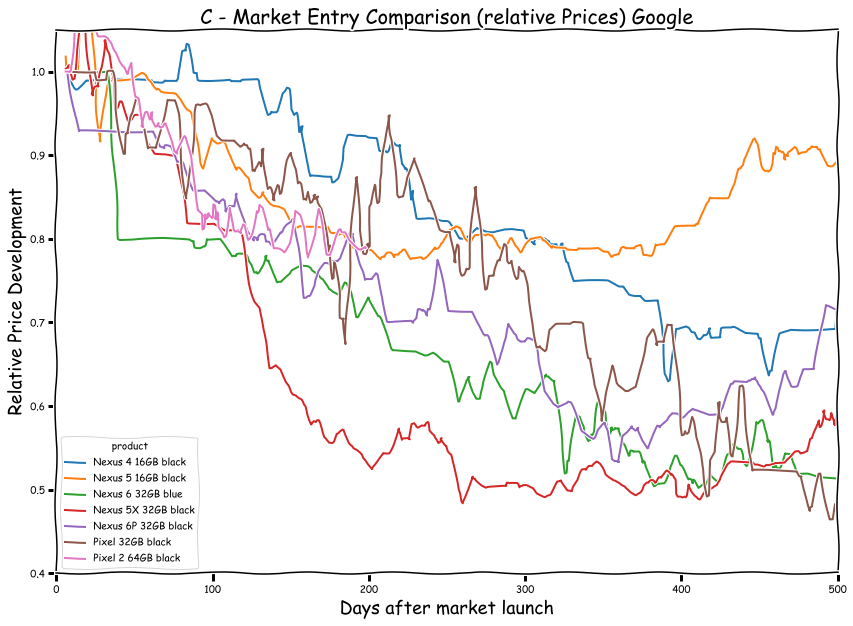

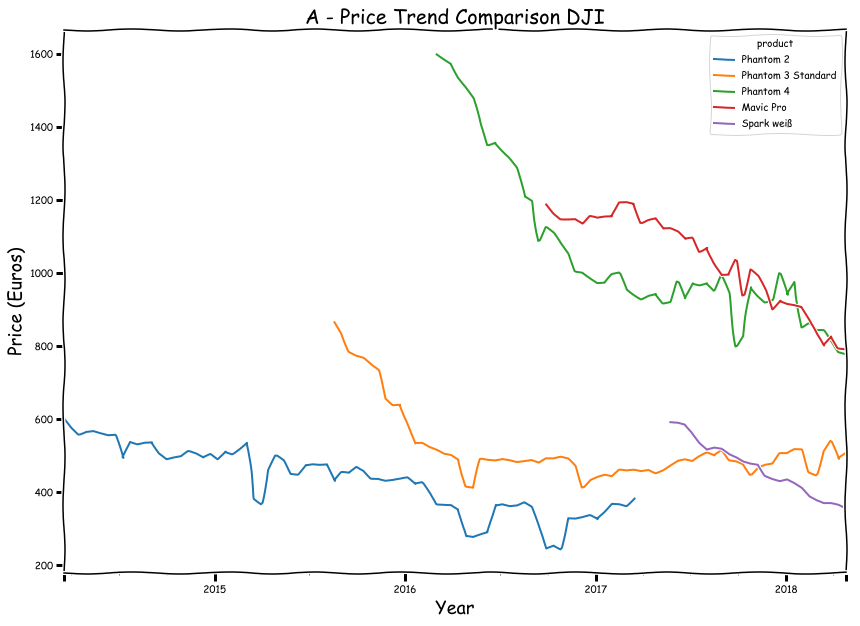

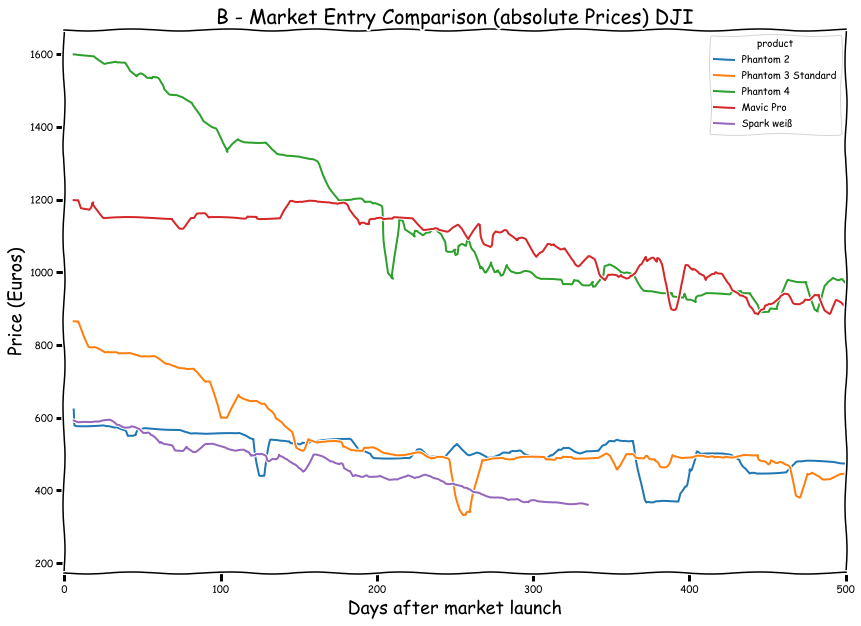

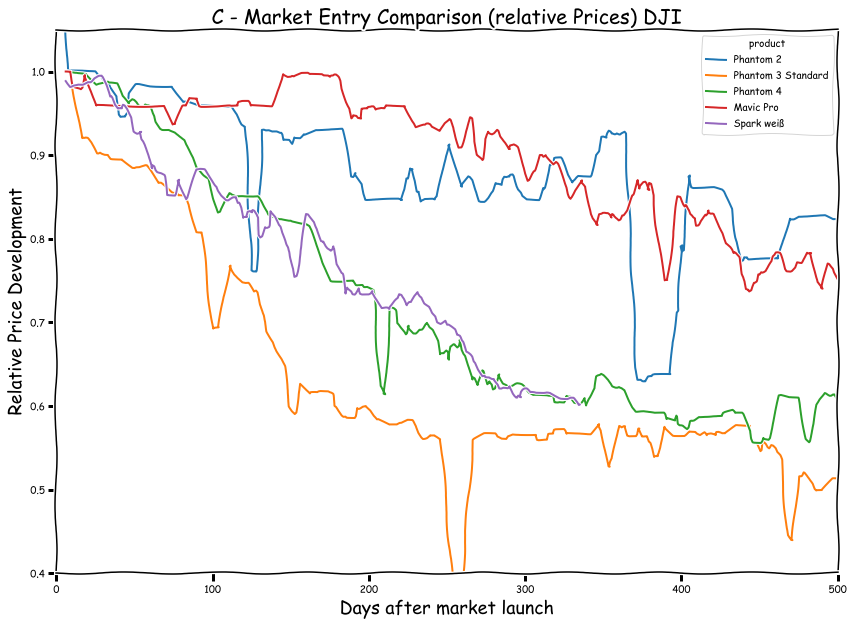

In [6]:
manufacturer_list = df_raw['manufacturer'].unique().tolist()

for manufacturer in manufacturer_list:

    df_manufacturer = df_raw.loc[df_raw['manufacturer'] == manufacturer]
    product_names = df_manufacturer['product'].unique().tolist()

    title = 'A - Price Trend Comparison '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='timestamp', columns='product', values='price').resample('14D').mean()
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10))
    plt.title(title, fontsize=20)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Price (Euros)', fontsize=18)
    fig = ax.get_figure()
    outfile = title+'.png'
    fig.savefig(os.path.join('../figures', outfile))
    del ax, fig, df_figure

    title = 'B - Market Entry Comparison (absolute Prices) '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='market_day', columns='product', values='price_avg_week')
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), xlim=(0, 500))
    plt.title(title, fontsize=20)
    plt.xlabel('Days after market launch', fontsize=18)
    plt.ylabel('Price (Euros)', fontsize=18)
    fig = ax.get_figure()
    outfile = title+'.png'
    fig.savefig(os.path.join('../figures', outfile))
    del ax, fig, df_figure

    title = 'C - Market Entry Comparison (relative Prices) '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='market_day', columns='product', values='price_perc_week')
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), xlim=(0, 500), ylim=(0.4, 1.05))
    plt.title(title, fontsize=20)
    plt.xlabel('Days after market launch', fontsize=18)
    plt.ylabel('Relative Price Development', fontsize=18)
    fig = ax.get_figure()
    outfile = title+'.png'
    fig.savefig(os.path.join('../figures', outfile))
    del ax, fig, df_figure